# Introducción

Siguiendo con lo realizado en el trabajo anterior, donde se compararon distintos modelos de aprendizaje automático para ver su eficacia detectando fuego utilizando una bateria de sensores, utilizando un dataset externo, en este trabajo pretendemos evaluar qué tan bien resisten distintos modelos de aprendizaje automático a la falla en alguno de los 12 sensores utilizados.

En este trabajo se estudiarán 2 posibles escenarios, que a su vez cada uno se divide en 12 sub escenarios.
* El primer escenario consiste en que uno de los 12 sensores deje de funcionar, y se evaluará la eficacia del modelo de Random Forest, que resultó ser el mejor en el caso original, en base solo a las 11 variables restantes. En este caso no se evaluan más modelos porque hay que hacer una versión de cada modelo para cada conjunto de sensores y eso es computacionalmente muy costoso para los alcances de este estudio.
* En el segundo escenario, el sensor que falla dará información erronea pero el modelo no sabrá que este falla. Se evaluará como se comportan en este escenario los modelos de Random Forest, Regresión Logistica Simple y una red neuronal más compleja.

# Código común

Este código, utilizado para importar modulos y datos, es similar al notebook anterior y se usa para ambos escenarios.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import tensorflow_decision_forests as tfdf
import IPython.display


Esta función se llamara al inicio de cada celda para garantizar la reproducibilidad

In [3]:
def Inicializar():
  np.random.seed(0)
  tf.random.set_seed(0)
  tfdf.keras.RandomForestModel.global_seed = 0

In [4]:
from google.colab import drive
#drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)
path = '/content/drive/MyDrive/IA IOT/'

Mounted at /content/drive


In [5]:
ruta_archivo = path + 'smoke_detection_iot.csv'
print(ruta_archivo)

/content/drive/MyDrive/IA IOT/smoke_detection_iot.csv


Importo los datos

In [6]:
Inicializar()
#data_set = pd.read_csv("smoke_detection_iot.csv")
data_set = pd.read_csv(ruta_archivo)
data_set = data_set.drop(["Unnamed: 0","UTC", "CNT"],axis=1)
data_set['Fire Alarm'] = data_set['Fire Alarm'].astype('category')
columnas_actuales = data_set.columns.tolist()

# Crear un diccionario para mapear los nombres de columnas originales a los nuevos nombres.
nuevos_nombres = {"Fire Alarm": "Y"}
for i, columna in enumerate(columnas_actuales):
    if columna != "Fire Alarm" and columna!="Y":
        nuevos_nombres[columna] = f"X{i+1}"

# Renombrar las columnas del DataFrame según el diccionario de nuevos nombres.
data_set.rename(columns=nuevos_nombres, inplace=True)
reverse = {v: k for k, v in nuevos_nombres.items()}
print(reverse)
data_set

{'Y': 'Fire Alarm', 'X1': 'Temperature[C]', 'X2': 'Humidity[%]', 'X3': 'TVOC[ppb]', 'X4': 'eCO2[ppm]', 'X5': 'Raw H2', 'X6': 'Raw Ethanol', 'X7': 'Pressure[hPa]', 'X8': 'PM1.0', 'X9': 'PM2.5', 'X10': 'NC0.5', 'X11': 'NC1.0', 'X12': 'NC2.5'}


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,Y
0,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,0.000,0.000,0
1,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,0.000,0.000,0
2,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,0.000,0.000,0
3,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,0.000,0.000,0
4,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,0.000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,0.673,0.015,0
62626,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,0.652,0.015,0
62627,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,0.617,0.014,0
62628,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,0.611,0.014,0


En este caso, como solo se busca comparar entre modelos y no tener un proceso de selección de modelos, solo se dividirá el dataset en 2. Un 70% para datos de entrenamiento y un 30% para datos de comparación.

Estos datos de comparación cumplen la función que usualmente se llama validación cruzada, por eso importante que los datos de comparación no se usen para entrenar a los modelos. Para evitar premiar el sobreajuste.

In [ ]:
Inicializar()
indices = np.arange(len(data_set))
np.random.shuffle(indices)
data_set = data_set.iloc[indices]

# Calcular el tamaño de cada conjunto
num_samples = len(data_set)
train_size = int(0.7 * num_samples)
comp_size = num_samples - train_size

dtrain = data_set.iloc[:train_size]
dcomp = data_set.iloc[train_size:]

In [ ]:
def Divisor(dataset):
    return (dataset[dataset.columns[:-1]],dataset[dataset.columns[-1]])

In [ ]:
def PasarADataSet(df):
    df2 = df.copy()
    df2 = df2.rename(
    columns = {s: s.replace(" ","_") for s in df2.columns}
    )
    return tfdf.keras.pd_dataframe_to_tf_dataset(df2, label="Y")

# Primer escenario

En este escenario se evaluarán 12 posibilidades, en cada una se considerará el dataset con una columna faltante y se expondrá la precisión en los datos de comparación

In [ ]:
tabla = PrettyTable()
tabla.field_names = ["Sensor anulado","Precisión Comp."]
# Evaluo el caso base

dstrain_loc = PasarADataSet(dtrain)
dscomp_loc = PasarADataSet(dcomp)
Inicializar()
modelo = tfdf.keras.RandomForestModel()
modelo.compile(metrics=["accuracy"])
historial = modelo.fit(dstrain_loc,validation_data=dscomp_loc, verbose=False).history
tabla.add_row(["-","{:.6f}".format(historial['val_accuracy'][0])])

for X in ["X"+str(i) for i in range(1,13)]:
  Inicializar()
  dstrain_loc = PasarADataSet(dtrain.drop(columns=[X]))
  dscomp_loc = PasarADataSet(dcomp.drop(columns=[X]))
  modelo = tfdf.keras.RandomForestModel()
  modelo.compile(metrics=["accuracy"])
  historial = modelo.fit(dstrain_loc,validation_data=dscomp_loc, verbose=False).history
  tabla.add_row([reverse[X],"{:.6f}".format(historial['val_accuracy'][0])])
  #print(f"Modelo sin {reverse[X]} en los datos de comparación tiene una precisión de: {historial['val_accuracy'][0]}")
IPython.display.clear_output()
print(tabla)

+----------------+-----------------+
| Sensor anulado | Precisión Comp. |
+----------------+-----------------+
|       -        |     0.999787    |
| Temperature[C] |     0.999787    |
|  Humidity[%]   |     0.999734    |
|   TVOC[ppb]    |     0.999042    |
|   eCO2[ppm]    |     0.999734    |
|     Raw H2     |     0.999734    |
|  Raw Ethanol   |     0.999734    |
| Pressure[hPa]  |     0.999681    |
|     PM1.0      |     0.999734    |
|     PM2.5      |     0.999734    |
|     NC0.5      |     0.999734    |
|     NC1.0      |     0.999734    |
|     NC2.5      |     0.999734    |
+----------------+-----------------+


Como se ve, el modelo de Random Forest en este ejemplo es robusto y la anulación de un solo sensor no reduce significamente la precisión del modelo para detectar fuego.

# Segundo escenario

En este segundo escenario se van a entrenar 4 modelos utilizando el dtrain completo, y luego se probara como se comportan cuando se agrega ruido en cada uno de los sensores.

## Modelos

In [ ]:
modelos = []
epochs = [100,250]
batch_sizes = [32,1024]

El primer modelo será una regresión logística simple, que en TensorFlow se implementa como una red neuronal con una única capa.

In [ ]:
Inicializar()

capa_normalizacion = tf.keras.layers.experimental.preprocessing.Normalization()
xtrain, ytrain = Divisor(dtrain)
capa_normalizacion.adapt(xtrain)
model = tf.keras.Sequential([
    capa_normalizacion,
    tf.keras.layers.Dense(1, activation="sigmoid")
])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
for i in range(len(epochs)):
  model.fit(xtrain,ytrain,epochs=epochs[i],verbose=1,batch_size=batch_sizes[i], callbacks=[early_stopping])

modelos.append(("Regresión Logistica Simple",model))

Epoch 1/100
1371/1371 [==============================] - 4s 2ms/step - loss: 0.4657 - accuracy: 0.8206
Epoch 2/100
1371/1371 [==============================] - 3s 2ms/step - loss: 0.3292 - accuracy: 0.8750
Epoch 3/100
1371/1371 [==============================] - 3s 2ms/step - loss: 0.2891 - accuracy: 0.8703
Epoch 4/100
1371/1371 [==============================] - 3s 2ms/step - loss: 0.2678 - accuracy: 0.8649
Epoch 5/100
1371/1371 [==============================] - 3s 2ms/step - loss: 0.2548 - accuracy: 0.8648
Epoch 6/100
1371/1371 [==============================] - 3s 2ms/step - loss: 0.2464 - accuracy: 0.8695
Epoch 7/100
1371/1371 [==============================] - 3s 2ms/step - loss: 0.2405 - accuracy: 0.8749
Epoch 8/100
1371/1371 [==============================] - 3s 2ms/step - loss: 0.2361 - accuracy: 0.8786
Epoch 9/100
1371/1371 [==============================] - 2s 2ms/step - loss: 0.2328 - accuracy: 0.8817
Epoch 10/100
1371/1371 [==============================] - 2s 2ms/step - l

El segundo y tercer modelo a considerar serán modelos de Red Neuronal multicapas. La diferencia es que en el tercer modelo se agregarán capas de dropout para evaluar como estas, cuya función es darle robustes al modelo y evitar el sobreajuste, previenen contra el error frunto de mala información de un sensor.

In [ ]:
Inicializar()

capa_normalizacion = tf.keras.layers.experimental.preprocessing.Normalization()
xtrain, ytrain = Divisor(dtrain)
capa_normalizacion.adapt(xtrain)
model = tf.keras.Sequential([
    capa_normalizacion,
    tf.keras.layers.Dense(25, activation="sigmoid"),
    tf.keras.layers.Dense(25, activation="sigmoid"),
    tf.keras.layers.Dense(25, activation="sigmoid"),
    tf.keras.layers.Dense(25, activation="sigmoid"),
    tf.keras.layers.Dense(25, activation="sigmoid"),
    tf.keras.layers.Dense(25, activation="sigmoid"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

for i in range(len(epochs)):
  model.fit(xtrain,ytrain,epochs=epochs[i],verbose=1,batch_size=batch_sizes[i], callbacks=[early_stopping])

modelos.append(("Red Neuronal sin Drop Out",model))

Epoch 1/100
1371/1371 [==============================] - 7s 3ms/step - loss: 0.4114 - accuracy: 0.8212
Epoch 2/100
1371/1371 [==============================] - 5s 4ms/step - loss: 0.2296 - accuracy: 0.8896
Epoch 3/100
1371/1371 [==============================] - 3s 3ms/step - loss: 0.2032 - accuracy: 0.9005
Epoch 4/100
1371/1371 [==============================] - 4s 3ms/step - loss: 0.1856 - accuracy: 0.9099
Epoch 5/100
1371/1371 [==============================] - 5s 3ms/step - loss: 0.1642 - accuracy: 0.9201
Epoch 6/100
1371/1371 [==============================] - 3s 3ms/step - loss: 0.1382 - accuracy: 0.9308
Epoch 7/100
1371/1371 [==============================] - 3s 2ms/step - loss: 0.1180 - accuracy: 0.9405
Epoch 8/100
1371/1371 [==============================] - 3s 2ms/step - loss: 0.1098 - accuracy: 0.9464
Epoch 9/100
1371/1371 [==============================] - 3s 3ms/step - loss: 0.1011 - accuracy: 0.9511
Epoch 10/100
1371/1371 [==============================] - 5s 3ms/step - l

In [ ]:
Inicializar()

capa_normalizacion = tf.keras.layers.experimental.preprocessing.Normalization()
xtrain, ytrain = Divisor(dtrain)
capa_normalizacion.adapt(xtrain)
model = tf.keras.Sequential([
    capa_normalizacion,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(25, activation="sigmoid"),
    tf.keras.layers.Dense(25, activation="sigmoid"),
    tf.keras.layers.Dense(25, activation="sigmoid"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(25, activation="sigmoid"),
    tf.keras.layers.Dense(25, activation="sigmoid"),
    tf.keras.layers.Dense(25, activation="sigmoid"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

for i in range(len(epochs)):
  model.fit(xtrain,ytrain,epochs=epochs[i],verbose=1,batch_size=batch_sizes[i], callbacks=[early_stopping])

modelos.append(("Red Neuronal con Drop Out",model))

Epoch 1/100
1371/1371 [==============================] - 6s 3ms/step - loss: 0.5549 - accuracy: 0.7521
Epoch 2/100
1371/1371 [==============================] - 3s 2ms/step - loss: 0.4362 - accuracy: 0.8487
Epoch 3/100
1371/1371 [==============================] - 3s 2ms/step - loss: 0.4272 - accuracy: 0.8510
Epoch 4/100
1371/1371 [==============================] - 4s 3ms/step - loss: 0.4236 - accuracy: 0.8521
Epoch 5/100
1371/1371 [==============================] - 5s 3ms/step - loss: 0.4215 - accuracy: 0.8517
Epoch 6/100
1371/1371 [==============================] - 4s 3ms/step - loss: 0.4210 - accuracy: 0.8508
Epoch 7/100
1371/1371 [==============================] - 3s 2ms/step - loss: 0.4156 - accuracy: 0.8521
Epoch 8/100
1371/1371 [==============================] - 3s 2ms/step - loss: 0.4090 - accuracy: 0.8513
Epoch 9/100
1371/1371 [==============================] - 3s 2ms/step - loss: 0.4041 - accuracy: 0.8529
Epoch 10/100
1371/1371 [==============================] - 5s 3ms/step - l

El cuarto modelo es el Random Forest, como el visto en el escenario primero.

In [ ]:
Inicializar()
dstrain_loc = PasarADataSet(dtrain)
model = tfdf.keras.RandomForestModel()
model.compile(metrics=["accuracy"])
model.fit(dstrain_loc, verbose=False)
modelos.append(("Random Forest",model))


Use /tmp/tmpcmd06var as temporary training directory


## Comparación

Para la comparación se busca utilizar un criterio que sea aplicable a todos los sensores si que su lógica necesite ser adaptada para cada caso particular.

Concretamente, para simular la falla en el vector Xi se creará un vector Ui, donde cada entrada sigue una distribución uniforme que entre los valores mínimo y máximo de Xi dentro de todo el dataset. Esto para que, vista de forma aislada, esta nueva observación siempre tenga sentido.

Luego, se elegirá un parametro α y se remplazan los valores de Xi por *Oi,α = (1-α) * Xi + α * Ui*. En este contexto, α representa qué tan comprometido está el sensor. Se verá para cada sensor como cada modelo se comporta para distintos valores de α.

In [ ]:
def Evaluar(modelo, X, U, alfa):
  dcomp_loc = dcomp.copy()
  dcomp_loc[X] = (1-alfa)*dcomp_loc[X]+alfa*U
  if modelo[0]=="Random Forest":
    dscomp_loc = PasarADataSet(dcomp_loc)
    return modelo[1].evaluate(dscomp_loc)[1]
  xloc, yloc = Divisor(dcomp_loc)
  return   modelo[1].evaluate(xloc,yloc)[1]

19/19 [==============================] - 1s 30ms/step - loss: 0.0000e+00 - accuracy: 0.9997


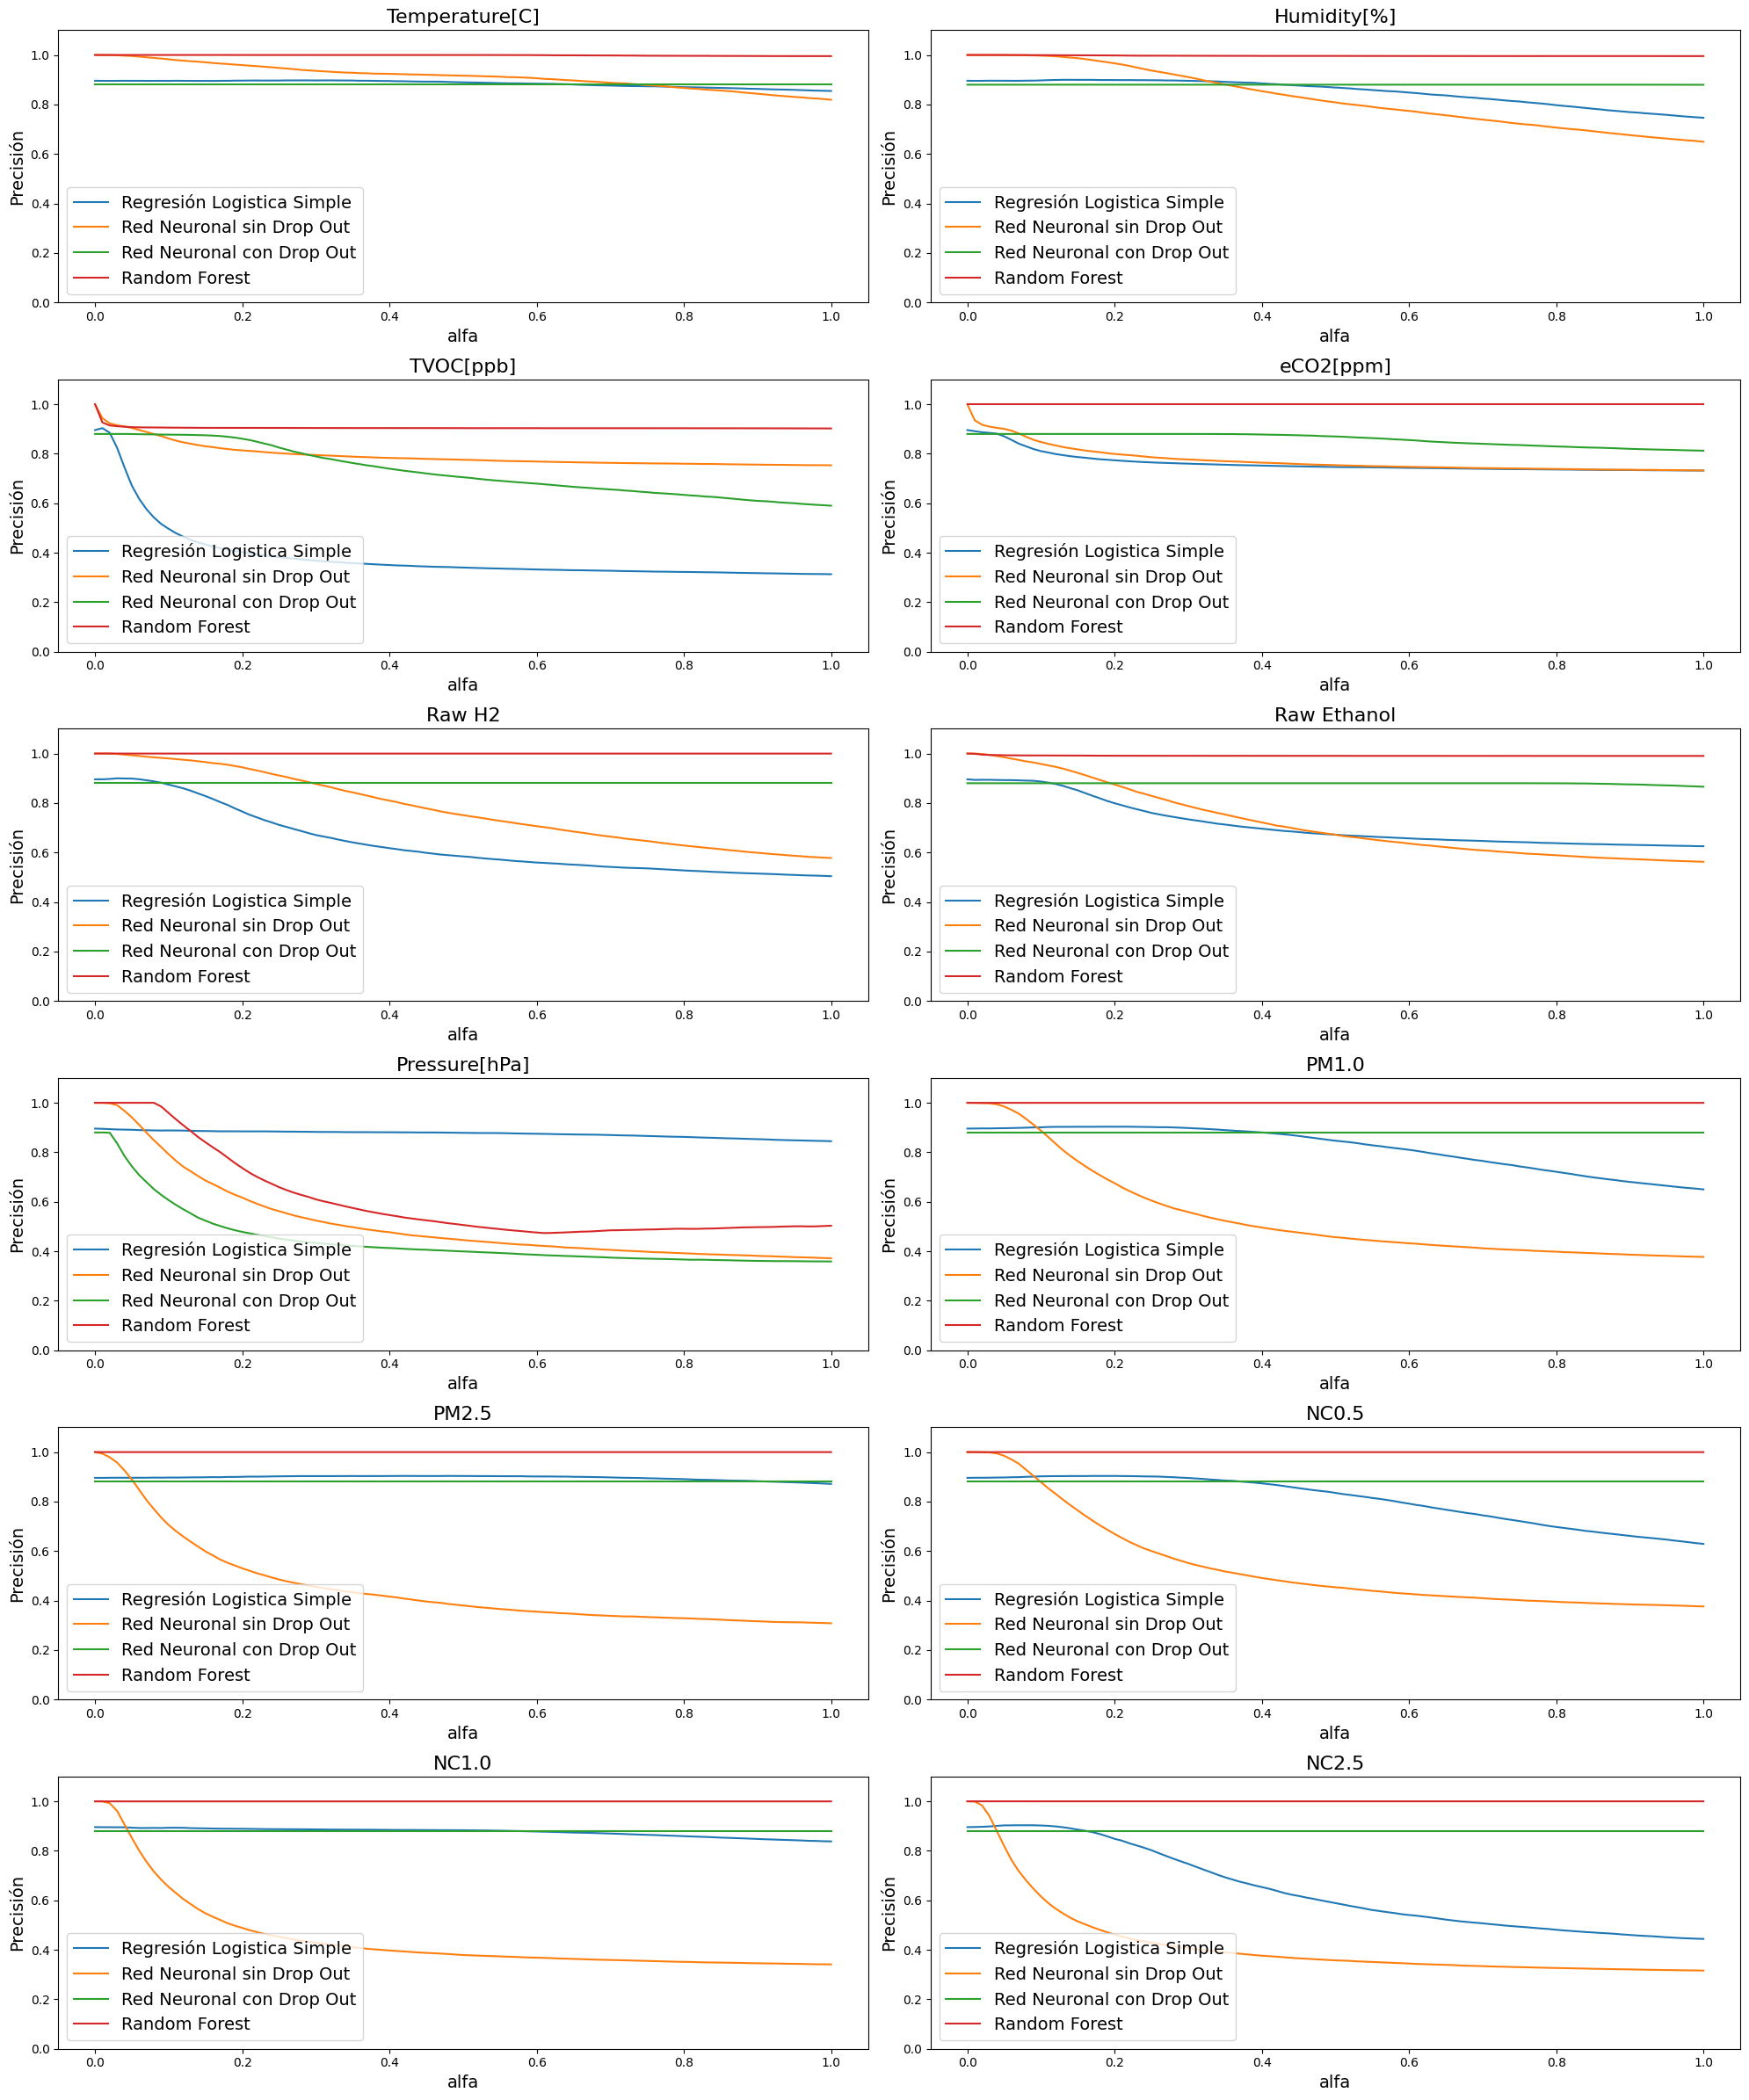

<Figure size 2240x1680 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(20, 24))

for i in range(12):
  Inicializar()
  ax = axs[i//2,i%2]
  X = "X"+str(i+1)
  minX, maxX = min(data_set[X]),max(data_set[X])
  U = np.random.uniform(minX, maxX, size=len(dcomp[X]))
  dom = np.linspace(0, 1, 101)
  for modelo in modelos:
    ax.plot(dom,[Evaluar(modelo,X,U,alfa) for alfa in dom], label=modelo[0])
  ax.set_title(reverse[X],fontsize=16)
  ax.legend(fontsize=14)
  ax.set_ylabel("Precisión",fontsize=14)
  ax.set_xlabel("alfa",fontsize=14)
  ax.set_ylim(0, 1.1)
  #ax.set_xlim(0, 1)

# Ajustar el espaciado entre los gráficos
plt.tight_layout()

# Mostrar la figura
plt.figure(dpi=350)
plt.show()
